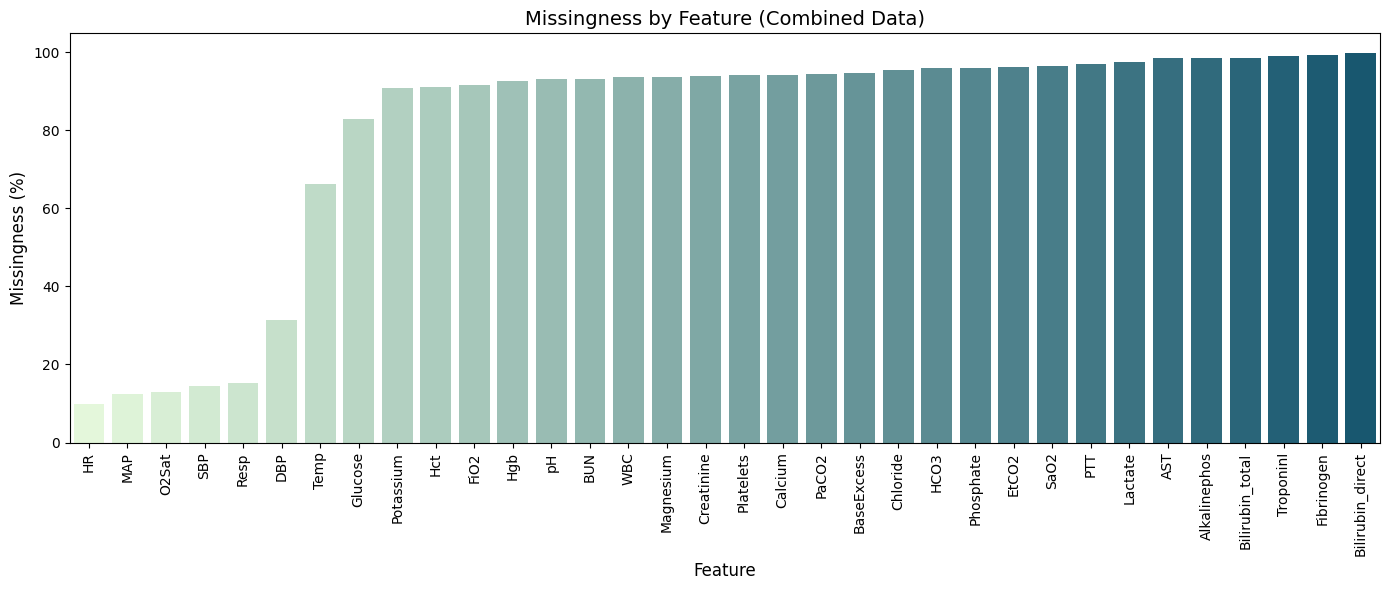

In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# Define paths
folder_a = "training_setA"
folder_b = "training_setB"

# Define relevant feature columns (indexes start from 0)
feature_columns = list(range(8)) + list(range(8, 34))

# Function to read all .psv files in a folder and extract relevant columns
def load_data(folder):
    data_frames = []
    for filename in os.listdir(folder):
        if filename.endswith(".psv"):
            file_path = os.path.join(folder, filename)
            df = pd.read_csv(file_path, sep='|')
            df = df.iloc[:, feature_columns]  # Select relevant columns
            data_frames.append(df)
    return pd.concat(data_frames, ignore_index=True)

# Load datasets
data_a = load_data(folder_a)
data_b = load_data(folder_b)

# Combine datasets
combined_data = pd.concat([data_a, data_b], ignore_index=True)

# Calculate missingness percentage
missingness = combined_data.isnull().mean() * 100
missingness = missingness.sort_values(ascending=True)  # Sort from least to most missing

# Create a custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["#e2fcd6", "#095d7e"])

# Plot missingness
plt.figure(figsize=(14, 6))
sns.barplot(x=missingness.index, y=missingness.values, palette=custom_cmap(np.linspace(0, 1, len(missingness))))

# Formatting
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Missingness (%)", fontsize=12)
plt.title("Missingness by Feature (Combined Data)", fontsize=14)

# Save and Show
plt.tight_layout()
plt.savefig("missingness_by_feature.png", dpi=300)
plt.show()


Calculated 9120 missing MAP values using MAP = (SBP + 2 * DBP) / 3
Calculated 45 missing SBP values using SBP = 3 * MAP - 2 * DBP
Calculated 256064 missing DBP values using DBP = (3 * MAP - SBP) / 2
Calculated 2205 missing Hct values using Hct = Hgb * 2.94
Calculated 25047 missing Hgb values using Hgb = Hct / 2.94
Calculated 115 missing pH values using pH = 6.1 + log10(HCO3 / (0.03 * PaCO2))
Calculated 68373 missing HCO3 values using HCO3 = 0.03 * PaCO2 * 10^(pH - 6.1)
Calculated 5841 missing PaCO2 values using PaCO2 = HCO3 / (0.03 * 10^(pH - 6.1))
Calculated 40136 missing BaseExcess values using BE = HCO3 - 24.4 + (2.3 * (Hgb - 7.4))
Calculated 1694 missing HCO3 values using HCO3 = BE + 24.4 - (2.3 * (Hgb - 7.4))
Calculated 41090 missing Hgb values using Hgb = ((BE - HCO3 + 24.4) / 2.3) + 7.4


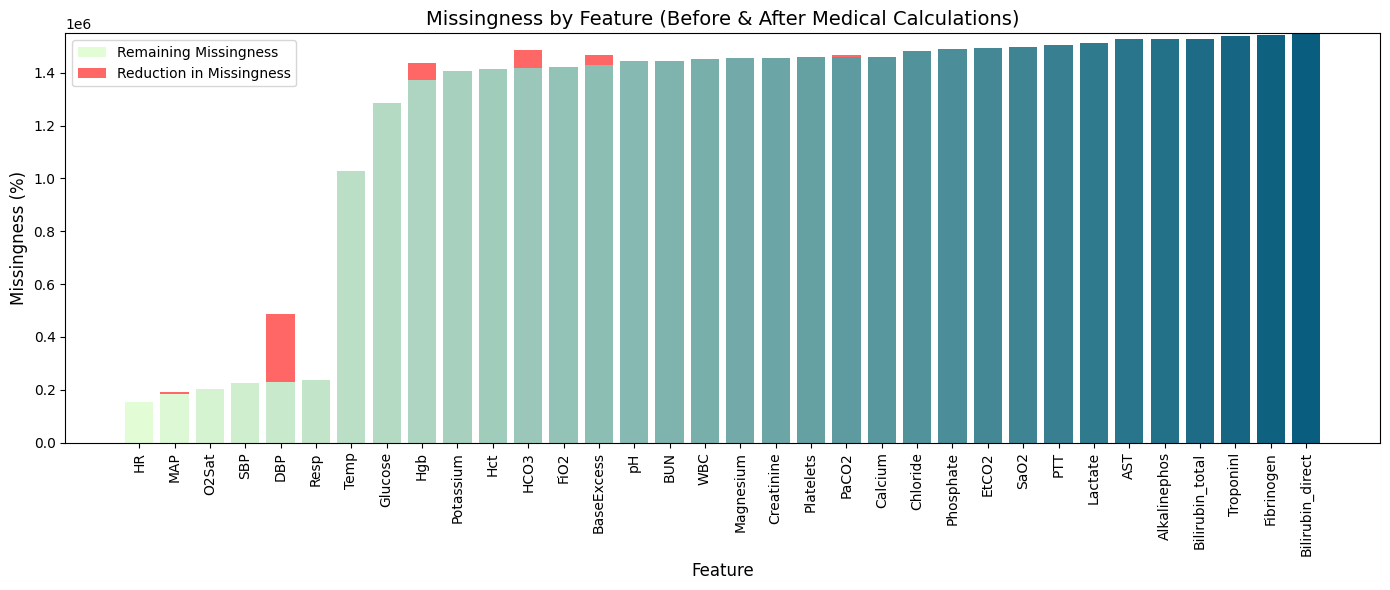

In [109]:
import pandas as pd
import numpy as np
import os

# 📌 Function to calculate missing values using medical equations
def calculate_missing_values(df, raw_features):
    df_calc = df.copy()  # Avoid modifying the original
    
    # 1. MAP = (SBP + 2 * DBP) / 3
    mask_map = df_calc['MAP'].isna() & df_calc['SBP'].notna() & df_calc['DBP'].notna()
    df_calc.loc[mask_map, 'MAP'] = (df_calc.loc[mask_map, 'SBP'] + 2 * df_calc.loc[mask_map, 'DBP']) / 3
    print(f"Calculated {mask_map.sum()} missing MAP values using MAP = (SBP + 2 * DBP) / 3")
    
    mask_sbp = df_calc['SBP'].isna() & df_calc['MAP'].notna() & df_calc['DBP'].notna()
    df_calc.loc[mask_sbp, 'SBP'] = 3 * df_calc.loc[mask_sbp, 'MAP'] - 2 * df_calc.loc[mask_sbp, 'DBP']
    print(f"Calculated {mask_sbp.sum()} missing SBP values using SBP = 3 * MAP - 2 * DBP")
    
    mask_dbp = df_calc['DBP'].isna() & df_calc['MAP'].notna() & df_calc['SBP'].notna()
    df_calc.loc[mask_dbp, 'DBP'] = (3 * df_calc.loc[mask_dbp, 'MAP'] - df_calc.loc[mask_dbp, 'SBP']) / 2
    print(f"Calculated {mask_dbp.sum()} missing DBP values using DBP = (3 * MAP - SBP) / 2")
    
    # 2. Hct = Hgb * 2.94
    mask_hct = df_calc['Hct'].isna() & df_calc['Hgb'].notna()
    df_calc.loc[mask_hct, 'Hct'] = df_calc.loc[mask_hct, 'Hgb'] * 2.94
    print(f"Calculated {mask_hct.sum()} missing Hct values using Hct = Hgb * 2.94")
    
    mask_hgb = df_calc['Hgb'].isna() & df_calc['Hct'].notna()
    df_calc.loc[mask_hgb, 'Hgb'] = df_calc.loc[mask_hgb, 'Hct'] / 2.94
    print(f"Calculated {mask_hgb.sum()} missing Hgb values using Hgb = Hct / 2.94")
    
    # 3. pH = 6.1 + log10(HCO3 / (0.03 * PaCO2))
    mask_ph = df_calc['pH'].isna() & df_calc['HCO3'].notna() & df_calc['PaCO2'].notna()
    if mask_ph.any():
        df_calc.loc[mask_ph, 'pH'] = 6.1 + np.log10(df_calc.loc[mask_ph, 'HCO3'] / 
                                                    (0.03 * df_calc.loc[mask_ph, 'PaCO2']))
        df_calc.loc[mask_ph & ((df_calc['pH'] < 6.8) | (df_calc['pH'] > 7.8)), 'pH'] = np.nan
        print(f"Calculated {mask_ph.sum()} missing pH values using pH = 6.1 + log10(HCO3 / (0.03 * PaCO2))")
    
    mask_hco3_ph = (df_calc['HCO3'].isna() & df_calc['pH'].notna() & df_calc['PaCO2'].notna() & 
                    df_calc['pH'].between(6.8, 7.8))
    if mask_hco3_ph.any():
        df_calc.loc[mask_hco3_ph, 'HCO3'] = 0.03 * df_calc.loc[mask_hco3_ph, 'PaCO2'] * \
                                            10 ** (df_calc.loc[mask_hco3_ph, 'pH'] - 6.1)
        print(f"Calculated {mask_hco3_ph.sum()} missing HCO3 values using HCO3 = 0.03 * PaCO2 * 10^(pH - 6.1)")
    
    mask_paco2_ph = (df_calc['PaCO2'].isna() & df_calc['pH'].notna() & df_calc['HCO3'].notna() & 
                     df_calc['pH'].between(6.8, 7.8))
    if mask_paco2_ph.any():
        df_calc.loc[mask_paco2_ph, 'PaCO2'] = df_calc.loc[mask_paco2_ph, 'HCO3'] / \
                                              (0.03 * 10 ** (df_calc.loc[mask_paco2_ph, 'pH'] - 6.1))
        print(f"Calculated {mask_paco2_ph.sum()} missing PaCO2 values using PaCO2 = HCO3 / (0.03 * 10^(pH - 6.1))")
    
    # 4. BaseExcess = HCO3 - 24.4 + (2.3 * (Hgb - 7.4))
    mask_be = df_calc['BaseExcess'].isna() & df_calc['HCO3'].notna() & df_calc['Hgb'].notna()
    if mask_be.any():
        df_calc.loc[mask_be, 'BaseExcess'] = (df_calc.loc[mask_be, 'HCO3'] - 24.4 + 
                                              2.3 * (df_calc.loc[mask_be, 'Hgb'] - 7.4))
        print(f"Calculated {mask_be.sum()} missing BaseExcess values using BE = HCO3 - 24.4 + (2.3 * (Hgb - 7.4))")
    
    mask_hco3_be = df_calc['HCO3'].isna() & df_calc['BaseExcess'].notna() & df_calc['Hgb'].notna()
    if mask_hco3_be.any():
        df_calc.loc[mask_hco3_be, 'HCO3'] = (df_calc.loc[mask_hco3_be, 'BaseExcess'] + 24.4 - 
                                             2.3 * (df_calc.loc[mask_hco3_be, 'Hgb'] - 7.4))
        print(f"Calculated {mask_hco3_be.sum()} missing HCO3 values using HCO3 = BE + 24.4 - (2.3 * (Hgb - 7.4))")
    
    mask_hgb_be = df_calc['Hgb'].isna() & df_calc['BaseExcess'].notna() & df_calc['HCO3'].notna()
    if mask_hgb_be.any():
        df_calc.loc[mask_hgb_be, 'Hgb'] = ((df_calc.loc[mask_hgb_be, 'BaseExcess'] - 
                                            df_calc.loc[mask_hgb_be, 'HCO3'] + 24.4) / 2.3 + 7.4)
        print(f"Calculated {mask_hgb_be.sum()} missing Hgb values using Hgb = ((BE - HCO3 + 24.4) / 2.3) + 7.4")
    
    return df_calc


raw_features = [
    'HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2', 'BaseExcess', 'HCO3', 
    'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN', 'Alkalinephos', 'Calcium', 'Chloride', 
    'Creatinine', 'Bilirubin_direct', 'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 
    'Potassium', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 
    'Platelets'
]


# Summary of changes
df_calculated = calculate_missing_values(combined_data, raw_features)
missing_before = combined_data[raw_features].isna().sum()
missing_after = df_calculated[raw_features].isna().sum()
missing_reduction = missing_before - missing_after


# Sort features by final missingness (after reduction)
sorted_features = missing_after.sort_values().index
missing_after = missing_after[sorted_features]
missing_reduction = missing_reduction[sorted_features]

# Create a custom colormap for the base bars
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_gradient", ["#e2fcd6", "#095d7e"])
gradient_colors = custom_cmap(np.linspace(0, 1, len(missing_after)))  # Generate gradient colors

# 📊 Plot missingness (after) with reduction stacked on top
plt.figure(figsize=(14, 6))

# Plot remaining missingness using gradient colors
bars_after = plt.bar(sorted_features, missing_after, color=gradient_colors, label="Remaining Missingness")

# Plot reduction in missingness in red
bars_reduction = plt.bar(sorted_features, missing_reduction, bottom=missing_after, color="red", alpha=0.6, label="Reduction in Missingness")

# Formatting
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Missingness (%)", fontsize=12)
plt.title("Missingness by Feature (Before & After Medical Calculations)", fontsize=14)
plt.legend()

# Save and Show
plt.tight_layout()
plt.savefig("missingness_by_feature_equations.png", dpi=300)
plt.show()

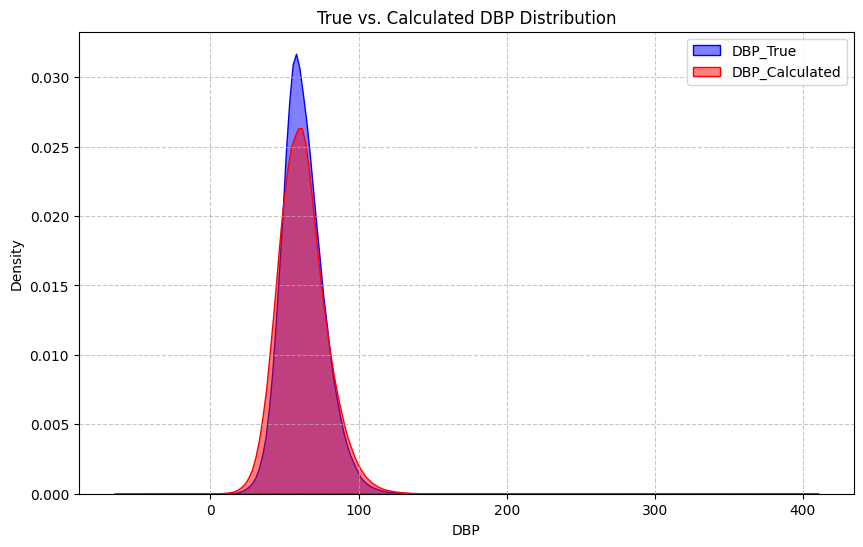

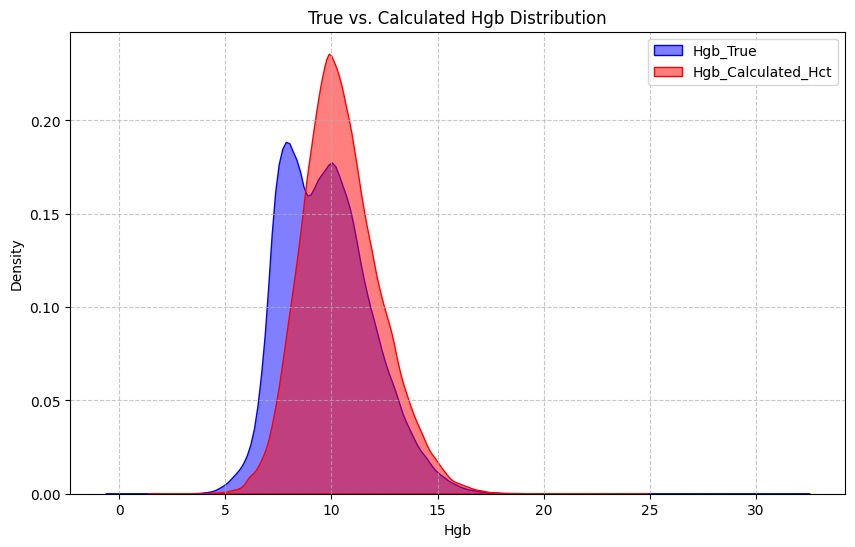

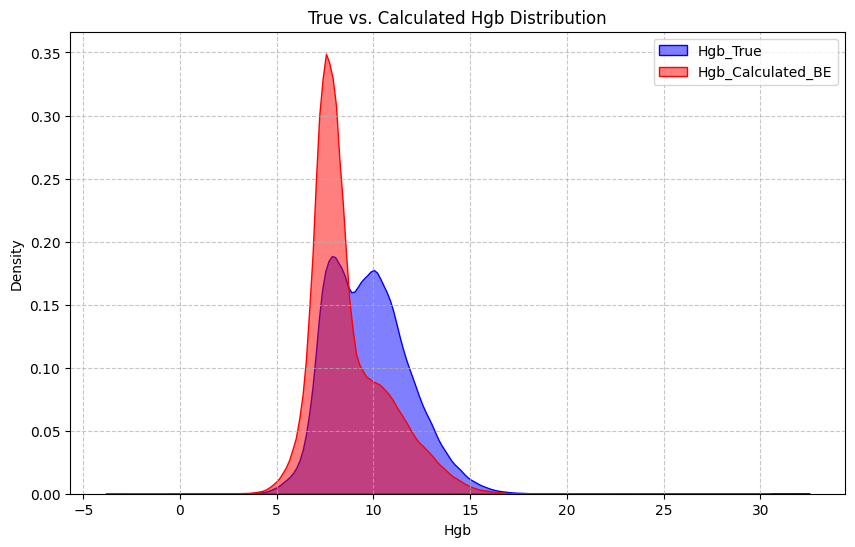

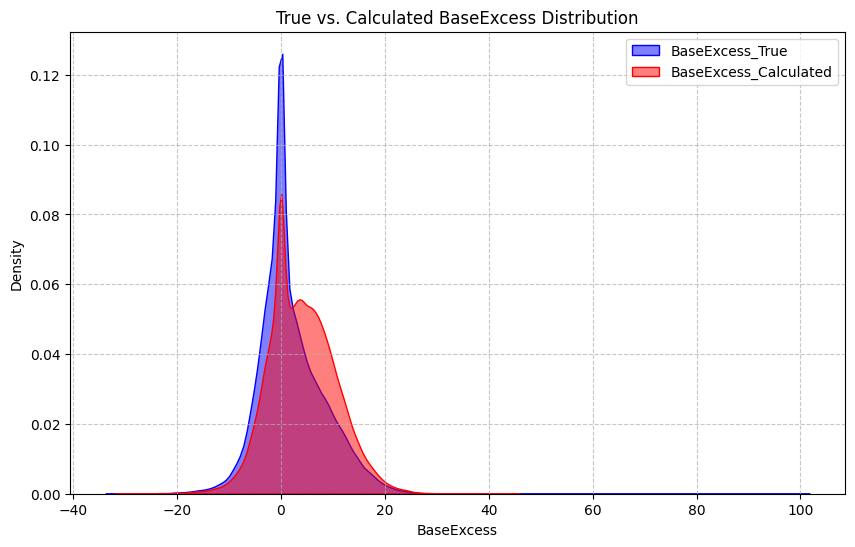

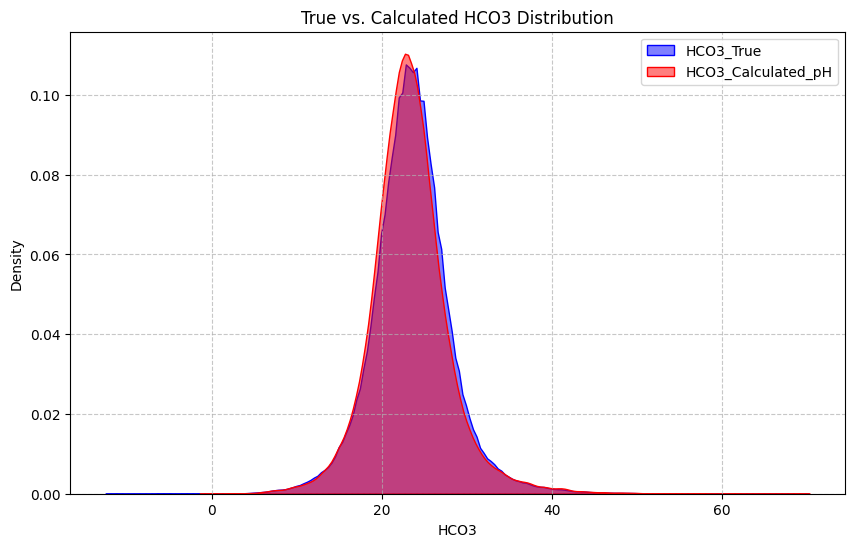

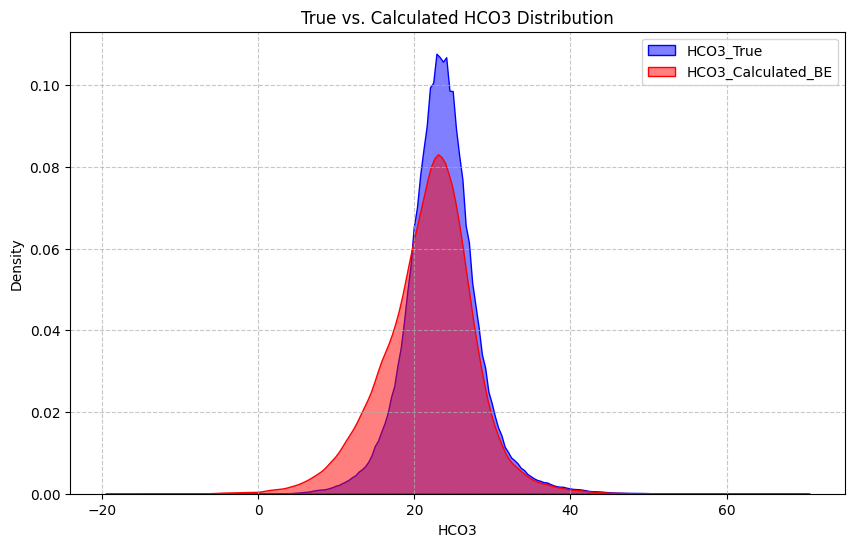

In [113]:
def plot_distribution_comparison(df, feature, calculated_feature, title="Feature Distribution Comparison"):
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(df[feature].dropna(), label=f"{feature}_True", fill=True, color="blue", alpha=0.5)
    sns.kdeplot(df[calculated_feature].dropna(), label=f"{calculated_feature}", fill=True, color="red", alpha=0.5)
    
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Save and show
    plt.savefig(f"{feature}_vs_{calculated_feature}_distribution.png", dpi=300, bbox_inches="tight")
    plt.show()

# 📌 Generate comparisons for all calculated variables
calculated_equations = {
    'DBP': ('DBP', 'MAP', 'SBP', "DBP_Calculated"),
    'Hgb_Hct': ('Hgb', 'Hct', None, "Hgb_Calculated_Hct"),
    'Hgb_BE': ('Hgb', 'BaseExcess', 'HCO3', "Hgb_Calculated_BE"),
    'BaseExcess': ('BaseExcess', 'HCO3', 'Hgb', "BaseExcess_Calculated"),
    'HCO3_pH': ('HCO3', 'pH', 'PaCO2', "HCO3_Calculated_pH"),
    'HCO3_BE': ('HCO3', 'BaseExcess', 'Hgb', "HCO3_Calculated_BE")
}

for key, (true_feature, feature1, feature2, calculated_feature) in calculated_equations.items():
    mask_valid = df_calculated[true_feature].notna() & df_calculated[feature1].notna()
    if feature2:
        mask_valid &= df_calculated[feature2].notna()
    
    if mask_valid.any():
        if key == 'DBP':
            df_calculated.loc[mask_valid, calculated_feature] = (
                (3 * df_calculated.loc[mask_valid, 'MAP'] - df_calculated.loc[mask_valid, 'SBP']) / 2)
        elif key == 'Hgb_Hct':
            df_calculated.loc[mask_valid, calculated_feature] = df_calculated.loc[mask_valid, 'Hct'] / 2.94
        elif key == 'Hgb_BE':
            df_calculated.loc[mask_valid, calculated_feature] = (df_calculated.loc[mask_valid, 'BaseExcess'] - df_calculated.loc[mask_valid, 'HCO3'] + 24.4) / 2.3 + 7.4

        elif key == 'BaseExcess':
            df_calculated.loc[mask_valid, calculated_feature] = (
                df_calculated.loc[mask_valid, 'HCO3'] - 24.4 + 2.3 * (df_calculated.loc[mask_valid, 'Hgb'] - 7.4))
        elif key == 'HCO3_pH':
            df_calculated.loc[mask_valid, calculated_feature] = 0.03 * df_calculated.loc[mask_valid, 'PaCO2'] * 10 ** (df_calculated.loc[mask_valid, 'pH'] - 6.1)
        elif key == 'HCO3_BE':
            df_calculated.loc[mask_valid, calculated_feature] = df_calculated.loc[mask_valid, 'BaseExcess'] + 24.4 - 2.3 * (df_calculated.loc[mask_valid, 'Hgb'] - 7.4)
        
        plot_distribution_comparison(df_calculated, true_feature, calculated_feature, title=f"True vs. Calculated {true_feature} Distribution")